In [1]:
import sys

# Setup

In [ ]:
# # To add your own Drive Run this cell.
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Please append your own directory after ‘/content/drive/My Drive/'
# where you have nutil.py and adult_subsample.csv
### ========== TODO : START ========== ###
# sys.path += ['/content/drive/My Drive/cm146/pset1']
# sys.path += ['/content/drive/']

### ========== TODO : END ========== ###


In [2]:
from nutil import *

In [3]:
# Use only the provided packages!
import math
import csv

from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

# Visualization

In [9]:
# Load the CSV file into a NumPy array
data = np.loadtxt('adult_subsample.csv', delimiter=',', skiprows=1)

# Check the shape of the array
print("Shape of data:", data.shape)

with open('adult_subsample.csv', 'r')as f:
    feature_names = f.readline().strip().split(',')

# Split into X (features) and y (target)
X = data[:, :-1]  # All columns except the last
y = data[:, -1]   # Last column

Shape of data: (1000, 15)


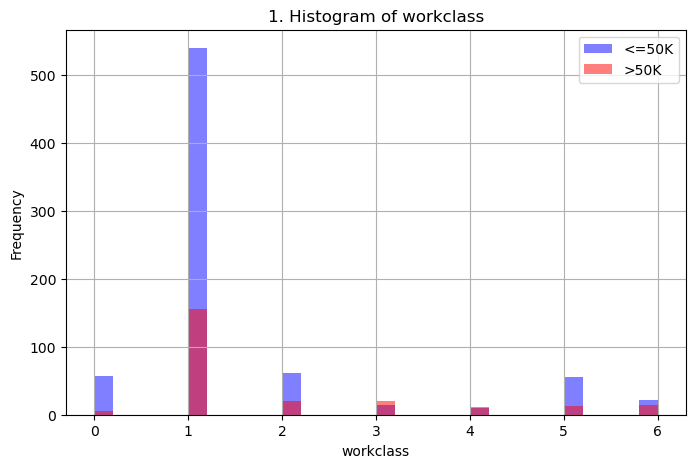

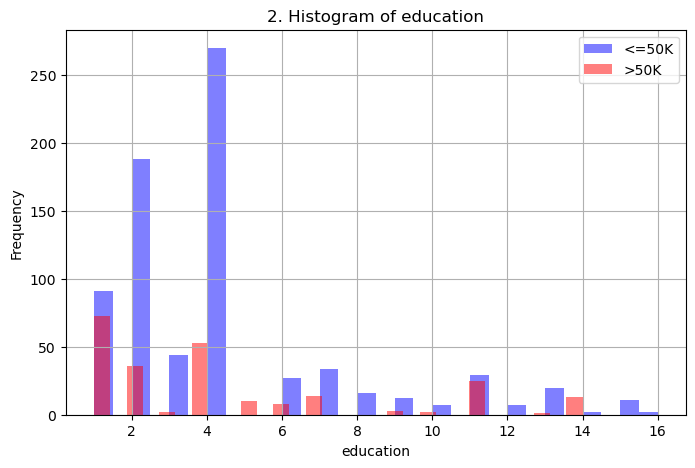

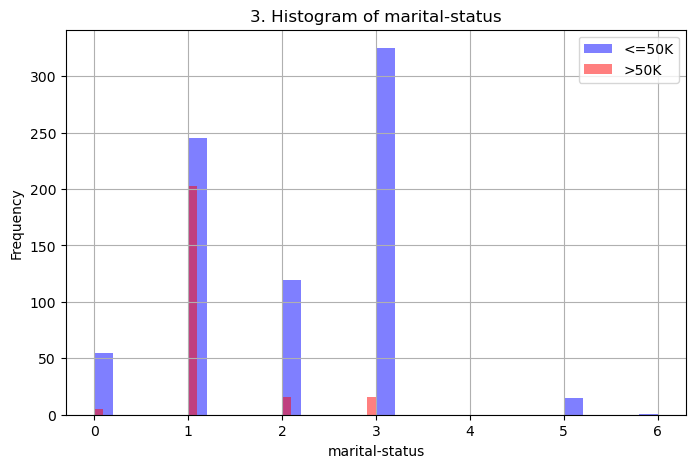

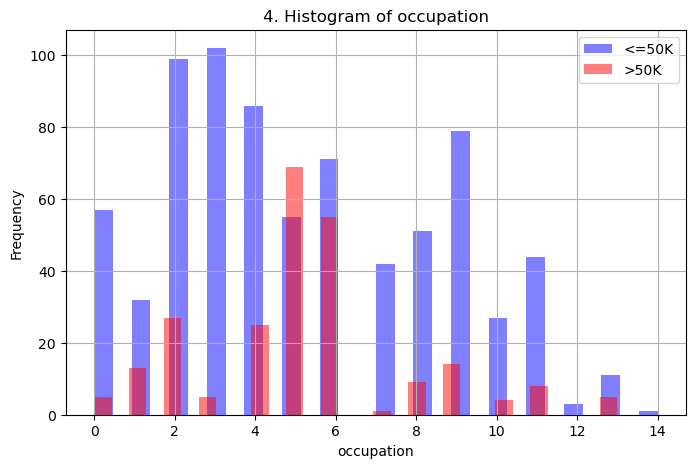

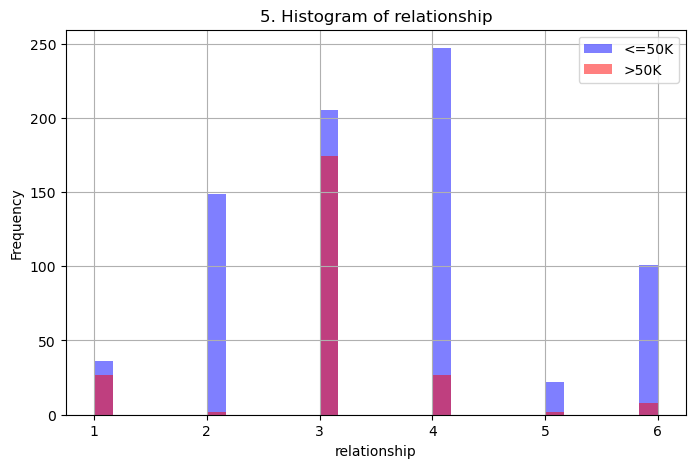

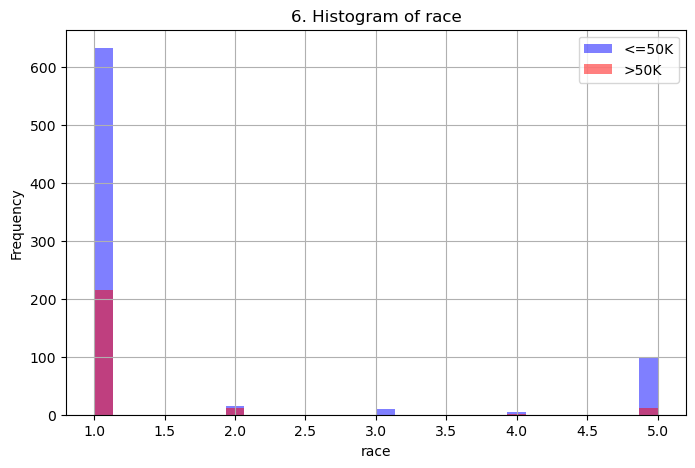

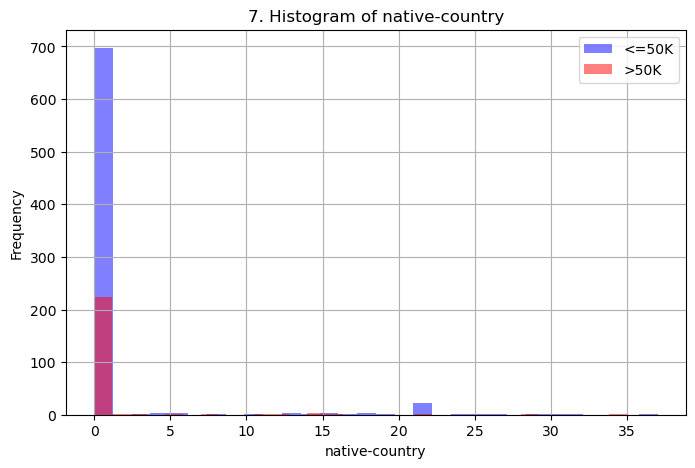

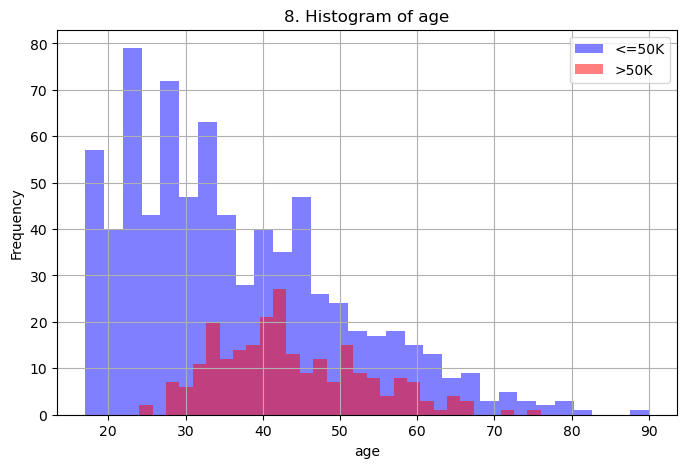

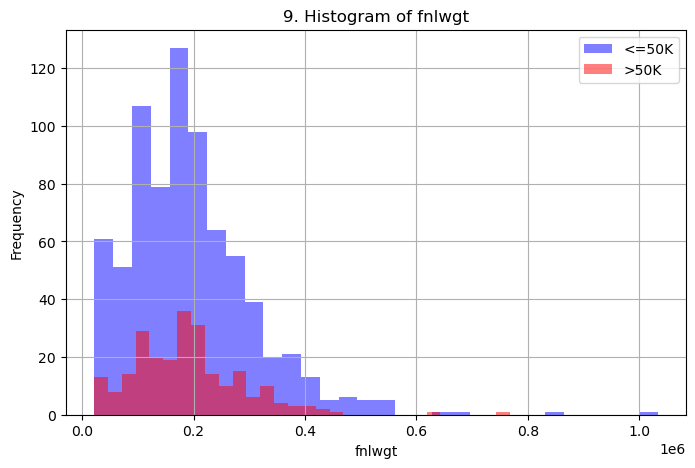

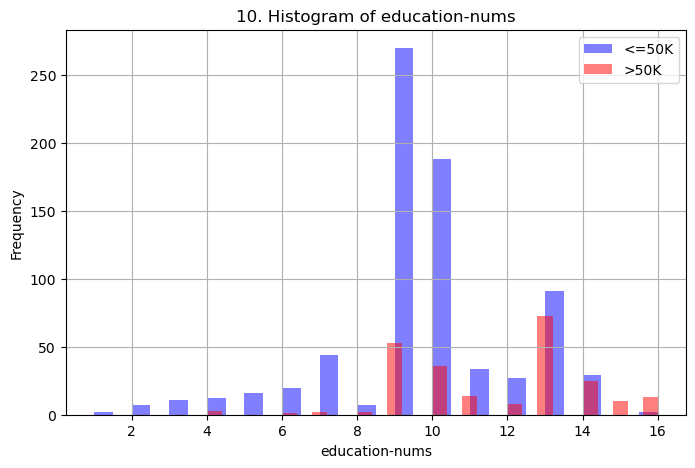

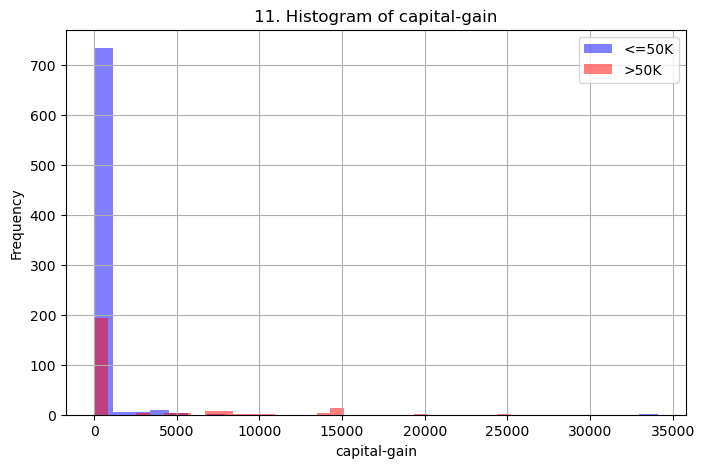

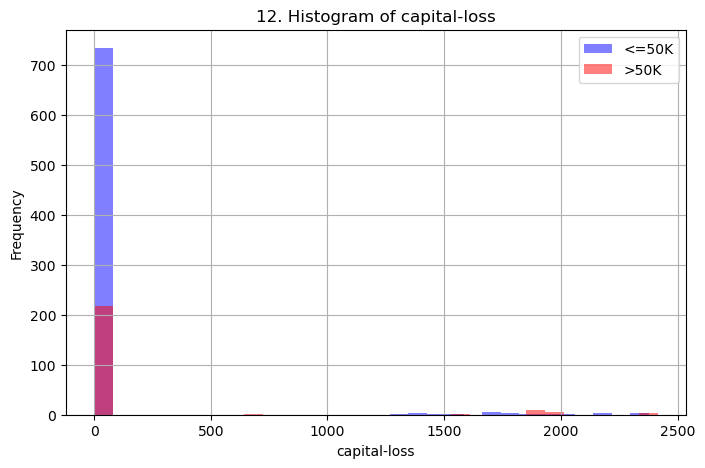

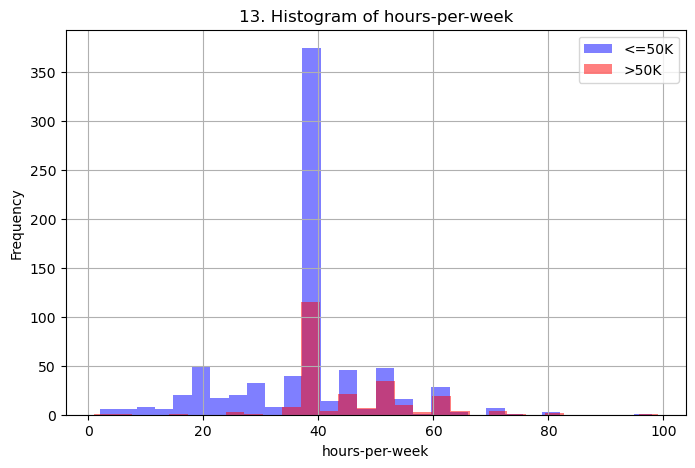

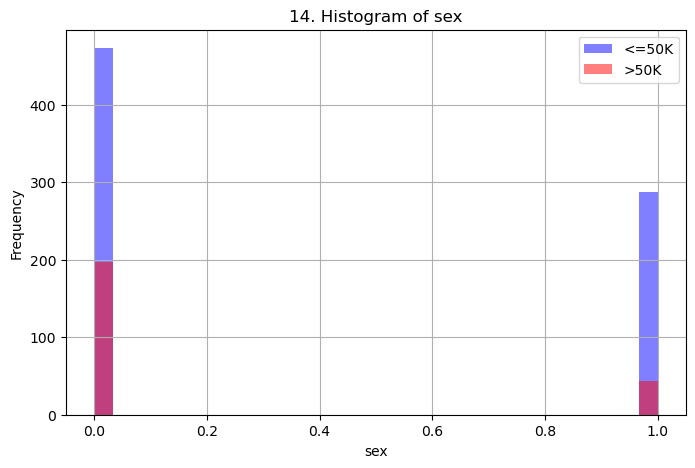

In [14]:
num_features = X.shape[1]
for i in range(num_features):
    feature = X[:, i]
    feature_name = f"{feature_names[i]}"
    
    feature_class_0 = feature[y==0]
    feature_class_1 = feature[y==1]
    
    plt.figure(figsize=(8,5))
    plt.hist(feature_class_0, bins=30, alpha=0.5, label="<=50K", color="blue")
    plt.hist(feature_class_1, bins=30, alpha=0.5, label=">50K", color="red")
    
    plt.title(f"{i+1}. Histogram of {feature_name}")
    plt.xlabel(feature_name)
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

# Income Classification Trends Based on Features

## **Observations for Each Feature**

### **1. workclass**
- Most individuals belong to a few specific workclasses.
- People earning **>50K** are slightly more concentrated in certain work classes compared to those earning **≤50K**.

### **2. education**
- Higher education levels tend to have a higher proportion of people earning **>50K**.
- The **≤50K** group is dominated by lower education levels.

### **3. marital-status**
- Married individuals have a higher likelihood of earning **>50K**.
- Single individuals are much more concentrated in the **≤50K** group.

### **4. occupation**
- Certain occupations have a higher number of **>50K** earners.
- The **≤50K** group is spread across multiple occupations, but some occupations rarely have high earners.

### **5. relationship**
- Married individuals (particularly those in a household head role) tend to earn more.
- Unmarried or dependent individuals are mostly in the **≤50K** group.

### **6. race**
- The distribution of **>50K** and **≤50K** follows the overall racial distribution in the dataset.
- There are no extreme differences in earning trends based on race.

### **7. native-country**
- Most high earners are from a few specific countries.
- The **≤50K** group has a more diverse spread across multiple countries.

### **8. age**
- Older individuals (especially above 40) have a higher proportion of **>50K** earners.
- The **≤50K** group has a higher concentration of younger individuals.

### **9. fnlwgt**
- No strong correlation with income; distribution looks similar across classes.
- This feature may not be a strong predictor of income.

### **10. education-nums**
- Higher values (more years of education) strongly correlate with **>50K** earnings.
- The majority of those with fewer years of education are in the **≤50K** category.

### **11. capital-gain**
- A strong indicator of **>50K** earnings, as high capital gains are almost exclusive to high-income individuals.
- Very few in the **≤50K** group have any capital gains.

### **12. capital-loss**
- Similar to capital gains, capital losses tend to be more common among **>50K** earners.
- Most people in the **≤50K** group have little to no capital loss.

### **13. hours-per-week**
- People working more than 40+ hours per week have a higher proportion of **>50K** earners.
- Those working fewer hours tend to belong to the **≤50K** group.

### **14. sex**
- Males have a higher percentage of **>50K** earners compared to females.
- The **≤50K** group is more evenly distributed across genders.



# Models

In [16]:
######################################################################
# Immutatble classes
######################################################################

class Classifier(object) :
    """
    Classifier interface.
    """

    def fit(self, X, y):
        raise NotImplementedError()

    def predict(self, X):
        raise NotImplementedError()


class MajorityVoteClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that always predicts the majority class.

        Attributes
        --------------------
            prediction_ -- majority class
        """
        self.prediction_ = None

    def fit(self, X, y) :
        """
        Build a majority vote classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """
        majority_val = Counter(y).most_common(1)[0][0]
        self.prediction_ = majority_val
        return self

    def predict(self, X) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.prediction_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")

        n,d = X.shape
        y = [self.prediction_] * n
        return y



In [21]:
######################################################################
# Mutatble classes
######################################################################

class RandomClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that predicts according to the distribution of the classes.

        Attributes
        --------------------
            probabilities_ -- class distribution dict (key = class, val = probability of class)
        """
        self.probabilities_ = None

    def fit(self, X, y) :
        """
        Build a random classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """

        ### ========== TODO : START ========== ###
        # part b: set self.probabilities_ according to the training set
        unique_classes, class_counts = np.unique(y, return_counts=True)
        total_samples = len(y)

        self.probabilities_ = {cls: count / total_samples for cls, count in zip(unique_classes, class_counts)}
        ### ========== TODO : END ========== ###

        return self

    def predict(self, X, seed=1234) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            seed -- integer, random seed

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.probabilities_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")
        np.random.seed(seed)

        ### ========== TODO : START ========== ###
        # part b: predict the class for each test example
        # hint: use np.random.choice (be careful of the parameters)
        num_samples = X.shape[0]
        classes = list(self.probabilities_.keys())
        probabilities = list(self.probabilities_.values())

        y = np.random.choice(classes, size=num_samples, p=probabilities)

        ### ========== TODO : END ========== ###

        return y
    
    def evaluate(self, X, y):
        """ Compute training error. """
        predictions = self.predict(X)
        error = np.mean(predictions != y)  # Fraction of incorrect predictions
        return error


In [23]:
X_train = X
y_train = y

# === Train and Evaluate Classifier ===
random_clf = RandomClassifier()
random_clf.fit(X_train, y_train)

# Compute error
training_error = random_clf.evaluate(X_train, y_train)
print(f"Training Error: {training_error:.3f}")  # Expected: ~0.374

Training Error: 0.374


# Auxiliary functions

In [ ]:
######################################################################
# Immutatble functions
######################################################################

def plot_histograms(X, y, Xnames, yname) :
    n,d = X.shape  # n = number of examples, d =  number of features
    fig = plt.figure(figsize=(20,15))
    ncol = 3
    nrow = d // ncol + 1
    for i in range(d) :
        fig.add_subplot (nrow,ncol,i+1)
        data, bins, align, labels = plot_histogram(X[:,i], y, Xname=Xnames[i], yname=yname, show = False)
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xnames[i])
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')

    plt.savefig ('histograms.pdf')


def plot_histogram(X, y, Xname, yname, show = True) :
    """
    Plots histogram of values in X grouped by y.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), feature values
        y     -- numpy array of shape (n,), target classes
        Xname -- string, name of feature
        yname -- string, name of target
    """

    # set up data for plotting
    targets = sorted(set(y))
    data = []; labels = []
    for target in targets :
        features = [X[i] for i in range(len(y)) if y[i] == target]
        data.append(features)
        labels.append('%s = %s' % (yname, target))

    # set up histogram bins
    features = set(X)
    nfeatures = len(features)
    test_range = list(range(int(math.floor(min(features))), int(math.ceil(max(features)))+1))
    if nfeatures < 10 and sorted(features) == test_range:
        bins = test_range + [test_range[-1] + 1] # add last bin
        align = 'left'
    else :
        bins = 10
        align = 'mid'

    # plot
    if show == True:
        plt.figure()
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xname)
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')
        plt.show()

    return data, bins, align, labels

In [ ]:
######################################################################
# Mutatble functions
######################################################################

def error(clf, X, y, ntrials=100, test_size=0.2) :
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.

    Parameters
    --------------------
        clf         -- classifier
        X           -- numpy array of shape (n,d), features values
        y           -- numpy array of shape (n,), target classes
        ntrials     -- integer, number of trials

    Returns
    --------------------
        train_error -- float, training error
        test_error  -- float, test error
        f1_score    -- float, test "micro" averaged f1 score
    """

    ### ========== TODO : START ========== ###
    # compute cross-validation error using StratifiedShuffleSplit over ntrials



    ### ========== TODO : END ========== ###

    return train_error, test_error, f1_score

In [ ]:
######################################################################
# Immutatble functions
######################################################################


def write_predictions(y_pred, filename, yname=None) :
    """Write out predictions to csv file."""
    out = open(filename, 'wb')
    f = csv.writer(out)
    if yname :
        f.writerow([yname])
    f.writerows(list(zip(y_pred)))
    out.close()

# Evaluation

In [ ]:

######################################################################
# main
######################################################################

def main():
    # load adult_subsample dataset with correct file path
    ### ========== TODO : START ========== ###
    data_file =  "/content/drive/My Drive/cm146/pset1/adult_subsample.csv"
    ### ========== TODO : END ========== ###


    data = load_data(data_file, header=1, predict_col=-1)

    X = data.X; Xnames = data.Xnames
    y = data.y; yname = data.yname
    n,d = X.shape  # n = number of examples, d =  number of features




    #========================================
    # part a: plot histograms of each feature
    print('Plotting...')
    plot_histograms (X, y, Xnames=Xnames, yname=yname)
    plt.show()



    ### ========== TODO : START ========== ###
    # part i: Preprocess X (e.g., normalize)
    # (try this after finishing the sections below)

    # X = ?

    ### ========== TODO : END ========== ###




    #========================================
    # train Majority Vote classifier on data
    print('Classifying using Majority Vote...')
    clf = MajorityVoteClassifier() # create MajorityVote classifier, which includes all model parameters
    clf.fit(X, y)                  # fit training data using the classifier
    y_pred = clf.predict(X)        # take the classifier and run it on the training data
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)





    ### ========== TODO : START ========== ###
    # part b: evaluate training error of Random classifier
    print('Classifying using Random...')
    clf = RandomClassifier ()

    # print('\t-- training error: %.3f' % train_error)
    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part c: evaluate training error of Decision Tree classifier
    print('Classifying using Decision Tree...')

    # print('\t-- training error: %.3f' % train_error)
    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part d: evaluate training error of k-Nearest Neighbors classifier
    # use k = 3, 5, 7 for n_neighbors
    print('Classifying using k-Nearest Neighbors...')


    # print the error for each k


    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part e: use cross-validation to compute average training and test error of classifiers
    print('Investigating various classifiers...')

    # clf =

    # summary = error(clf, X, y, ntrials=20)
    # print(summary)
    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part f: use 10-fold cross-validation to find the best value of k for k-Nearest Neighbors classifier
    print('Finding the best k...')



    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part g: investigate decision tree classifier with various depths
    print('Investigating depths...')



    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part h: investigate decision tree and k-Nearest Neighbors classifier with various training set sizes
    # hint: use train_test_split (use random_state=0 for consistent results)


    ### ========== TODO : END ========== ###



    print('Done')


if __name__ == "__main__":
    main()
